In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

# Script to analysis multislice simulation on antistie model
Use 3D output from Prismatic with correct frozen phonon applied.
<br>All simulations are without atomic displacement bug and processed with 20 phonons.

[]

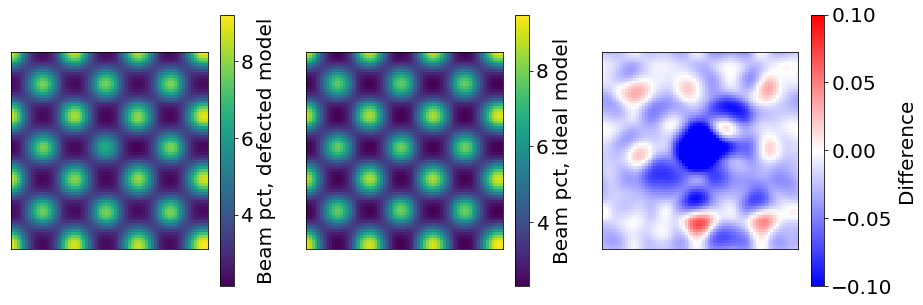

In [7]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/'

depth = 23
target_thickness = 12
slice = target_thickness+depth-27

antisite_cube =  loadMRCfile_3D(simpath + 'Depth' + str(depth) + '/' + 'slice' + str(slice) + '_depth' + str(depth) +'.mrc')
antisite_conv = Convolution_3D(antisite_cube,110)

perfect_cube = loadMRCfile_3D(simpath+'Depth0_OriginalPxSize/slice' +str(target_thickness-1)+'_depth0.mrc')
perfect_conv = Convolution_3D(perfect_cube,110)

antisite_2D = np.sum(antisite_conv[:,25:30,:],axis=1)
perfect_2D = np.sum(perfect_conv[:,25:30,:],axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

im0 = ax[0].imshow(antisite_2D*100)
# ax[0].scatter(30,33)
cbar = fig.colorbar(im0,ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Beam pct, defected model',fontsize=20)

im1 = ax[1].imshow(perfect_2D*100)
cbar = fig.colorbar(im1,ax=ax[1])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Beam pct, ideal model',fontsize=20)

im2 = ax[2].imshow((antisite_2D - perfect_2D)/perfect_2D,clim=[-0.1,0.1],cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(im2,ax=ax[2])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Difference',fontsize=20)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

In [11]:
# integrate Sr intensity on cBF-4 for all different configurations
mask = create_circular_mask(69, 69, center=[33,33], radius=5)
angle_limit = 10
# Each row saves one sample thickness, start from 8uc->row 0, first column is depth0, then depth3,4,5...
intensity_table = np.zeros((17,24))

for target_thickness in range(7,25):
    
    perfect_cube = loadMRCfile_3D(simpath+'Depth0_OriginalPxSize/slice' +str(target_thickness-1)+'_depth0.mrc')
    perfect_conv = Convolution_3D(perfect_cube,110)
    perfect_2D = np.sum(perfect_conv[:,0:angle_limit,:],axis=1)
    intensity_table[target_thickness-8,0] = np.sum(perfect_2D*mask)/np.sum(mask)
    
    for depth in range(3,26):
        slice = target_thickness+depth-27
        if slice >= 0:

            antisite_cube =  loadMRCfile_3D(simpath + 'Depth' + str(depth) + '/' + 'slice' + str(slice) + '_depth' + str(depth) +'.mrc')
            antisite_conv = Convolution_3D(antisite_cube,110)
            antisite_2D = np.sum(antisite_conv[:,0:angle_limit,:],axis=1)
            intensity_table[target_thickness - 8,depth-2] = np.sum(antisite_2D*mask)/np.sum(mask)



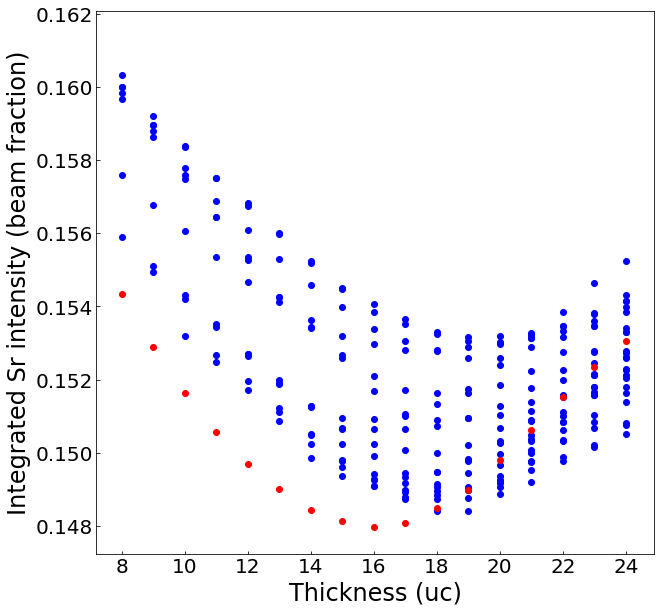

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.set_xlabel('Thickness (uc)',fontsize=24)
axes.set_ylabel('Integrated Sr intensity (beam fraction)',fontsize=24)
for i in range(intensity_table.shape[0]):
    
    for j in range(1,intensity_table.shape[1]):
        if intensity_table[i,j] != 0:
            axes.scatter(i+8,intensity_table[i,j],c='blue',marker='o')
            
    axes.scatter(i+8,intensity_table[i,0],c='red')
    
axes.tick_params(labelsize='20',direction='in')
# axes.set_ylim([0.02,0.026])
# axes.legend(fontsize='20')
    
path = '/srv/home/chenyu/DEbackup/022119/'
name = 'S5/'

# peaks_thickness = np.load(path + name + 'SrPeaks_thickness.npy')
# peaks_cBF4 = np.load(path+name+'SrPeaks_cBF10.npy')
# peaks_y = np.load(path+name + 'SrPeaks_y.npy')

# for i in range(peaks_thickness.shape[0]):
#     if peaks_y[i] > 70:
#         axes.scatter(peaks_thickness[i],peaks_cBF4[i],c='green')

# Aux functions

In [3]:
import struct
import mrcfile
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time

def loadMRCfile_3D(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(12)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        frame_layer = struct.unpack('<i',read_bytes[8:12])
        frame_layer = frame_layer[0]
        # frame_layer should be the slowest changing dimensiion in the data, thus the first layer in the reading loop
        image = np.zeros((frame_height,frame_width,frame_layer))

        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*frame_layer*4)
        
        for ilayer in range(frame_layer):
            for irow in range(frame_height):
                for icol in range(frame_width):
                    pixel = struct.unpack('<f',dataset[(ilayer*frame_width*frame_height+irow*frame_width+icol)*4:(ilayer*frame_width*frame_height+irow*frame_width+icol+1)*4])[0]
                    image[irow,icol,ilayer] = pixel
        return image

In [4]:
# currently only work for layer coordinate at the second place
def Convolution_3D(datacube,source_size):
    px_size = 17.5
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,datacube.shape[0])
    fkernel = np.fft.fft2(kernel)
    #initialize result array
    result = np.zeros(datacube.shape,dtype=np.float32)
    #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
    for ilayer in range(datacube.shape[1]):
        result[:,ilayer,:] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(datacube[:,ilayer,:]))).real
    
    return(result)

In [5]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [6]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask